Source: https://gist.github.com/VikingPenguinYT/665769ba03115b1a0888893eaf1d4f13

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.distributions import Bernoulli

In [18]:
class VariationalDense:
    """Variational Dense Layer Class"""
    def __init__(self, n_in, n_out, model_prob, model_lam):
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs=self.model_prob, dtype=tf.float32)
        self.model_M = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.01))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample((n_in, ))), self.model_M
        )

    def __call__(self, X, activation=tf.identity):
        output = activation(tf.matmul(X, self.model_W) + self.model_m)
        if self.model_M.shape[1] == 1:
            output = tf.squeeze(output)
        return output

    @property
    def regularization(self):
        # Eqn. (4)
        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
            tf.reduce_sum(tf.square(self.model_m))
        )

Sample data

In [19]:
n_samples = 50
X = np.random.normal(size=(n_samples, 1))
y = np.random.normal(np.cos(5.*X) / (np.abs(X) + 1.), 0.1).ravel()
X_pred = np.atleast_2d(np.linspace(-5., 5., num=500)).T
X = np.hstack((X, X**2, X**3))
X_pred = np.hstack((X_pred, X_pred**2, X_pred**3))

Create model

In [20]:
tf.reset_default_graph()

n_feats = X.shape[1]
n_hidden = 100
model_prob = 0.9
model_lam = 1e-2
model_X = tf.placeholder(tf.float32, [None, n_feats])
model_y = tf.placeholder(tf.float32, [None])
model_L_1 = VariationalDense(n_feats, n_hidden, model_prob, model_lam)
model_L_2 = VariationalDense(n_hidden, n_hidden, model_prob, model_lam)
model_L_3 = VariationalDense(n_hidden, 1, model_prob, model_lam)
model_out_1 = model_L_1(model_X, tf.nn.relu)
model_out_2 = model_L_2(model_out_1, tf.nn.relu)
model_pred = model_L_3(model_out_2)
model_sse = tf.reduce_sum(tf.square(model_y - model_pred))
model_mse = model_sse / n_samples
model_loss = (
    # Negative log-likelihood.
    model_sse +
    # Regularization.
    model_L_1.regularization +
    model_L_2.regularization +
    model_L_3.regularization
) / n_samples
train_step = tf.train.AdamOptimizer(1e-3).minimize(model_loss)

Train model

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [22]:
for i in range(10000):
    sess.run(train_step, {model_X: X, model_y: y})
    if i % 100 == 0:
        mse = sess.run(model_mse, {model_X: X, model_y: y})
        print("Iteration {}. Mean squared error: {:.4f}.".format(i, mse))

# Sample from the posterior.
n_post = 1000
Y_post = np.zeros((n_post, X_pred.shape[0]))
for i in range(n_post):
    Y_post[i] = sess.run(model_pred, {model_X: X_pred})

Iteration 0. Mean squared error: 0.1793.
Iteration 100. Mean squared error: 0.0991.
Iteration 200. Mean squared error: 0.0431.
Iteration 300. Mean squared error: 0.0197.
Iteration 400. Mean squared error: 0.0141.
Iteration 500. Mean squared error: 0.0172.
Iteration 600. Mean squared error: 0.0154.
Iteration 700. Mean squared error: 0.2001.
Iteration 800. Mean squared error: 0.0096.
Iteration 900. Mean squared error: 0.0303.
Iteration 1000. Mean squared error: 0.0126.
Iteration 1100. Mean squared error: 0.1134.
Iteration 1200. Mean squared error: 0.0115.
Iteration 1300. Mean squared error: 0.0171.
Iteration 1400. Mean squared error: 0.0226.
Iteration 1500. Mean squared error: 0.0210.
Iteration 1600. Mean squared error: 0.0106.
Iteration 1700. Mean squared error: 0.0308.
Iteration 1800. Mean squared error: 0.0929.
Iteration 1900. Mean squared error: 0.0235.
Iteration 2000. Mean squared error: 0.0087.
Iteration 2100. Mean squared error: 0.0152.
Iteration 2200. Mean squared error: 0.0089.


In [23]:
# Sample from the posterior.
n_post = 1000
Y_post = np.zeros((n_post, X_pred.shape[0]))
for i in range(n_post):
    Y_post[i] = sess.run(model_pred, {model_X: X_pred})

Plot

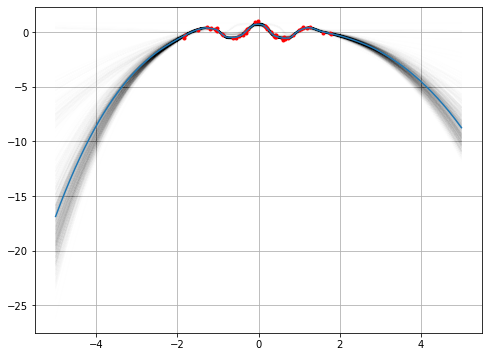

In [24]:
plt.figure(figsize=(8, 6))
for i in range(n_post):
    plt.plot(X_pred[:, 0], Y_post[i], "k-", alpha=1. / 200)
plt.plot(X[:, 0], y, "r.")
plt.plot(X_pred[:, 0], np.mean(Y_post.T, axis=1))
plt.grid()
plt.show()

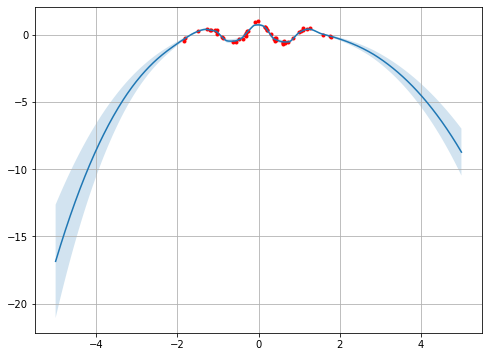

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(X[:, 0], y, "r.")
pred_mean = np.mean(Y_post.T, axis=1)
pred_std  = np.std(Y_post.T, axis=1)
plt.plot(X_pred[:,0], np.mean(Y_post.T, axis=1))
plt.fill_between(X_pred[:,0], pred_mean+pred_std, pred_mean-pred_std, alpha = 0.2)
plt.grid()
plt.show()